# Advance Lane Lines

The Project
---

The goal of this project is to develop a pipeline to process a video stream from a forward-facing camera mounted on the front of a car, and output an annotated video which identifies:

* The positions of the lane lines
* The location of the vehicle relative to the center of the lane
* The radius of curvature of the road

The steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2.  Apply a distortion correction to raw images.
3.  Apply a perspective transform to rectify binary image ("birds-eye view").
4.  Use color HLS color filtering transforms and sobel gradients to create a thresholded binary image.
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [83]:
import os
import numpy as np
import glob
import cv2
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Camera calibration and distorsion correction

The code use for the camara calibratio is base in the Udacity repository:  [CarND-Camera-Calibration](https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb)

To calibrate the camera we shall create the image and object points.
The image points are points in images taken with the camera that can be mapped to a object points (reference points).

The object points are the same for all the images as all the calibration images are chess boards of the same dimension (6x9). 

The images points are arrays with the coordinates of the corners of the chess board.

In [90]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
                                          
print("Object point (1st row):")
print(objp[0:9,:])                                          

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

print("\nImages uses for calibrate the camera: ")
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        print(idx, " ", end="")
        objpoints.append(objp)
        imgpoints.append(corners)

print("\n\nImages points (1st row):")
print(imgpoints[-1][0:9,0])

Object point (1st row):
[[ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 2.  0.  0.]
 [ 3.  0.  0.]
 [ 4.  0.  0.]
 [ 5.  0.  0.]
 [ 6.  0.  0.]
 [ 7.  0.  0.]
 [ 8.  0.  0.]]

Images uses for calibrate the camera: 
1  2  3  4  5  6  7  8  9  10  11  12  13  16  17  18  19  

Images points (1st row):
[[ 622.59265137  147.06881714]
 [ 661.09936523  162.3087616 ]
 [ 697.16424561  177.31687927]
 [ 731.43341064  191.54307556]
 [ 763.58007812  205.2311554 ]
 [ 793.96057129  218.34494019]
 [ 822.22521973  230.58702087]
 [ 849.57891846  242.73017883]
 [ 874.94610596  253.94567871]]


The coordinates of the corners in the image point are saved and they will be compared with object points to calibrate the camera. The calibration camera uses multiple images, in our case we have 19 calibration images.

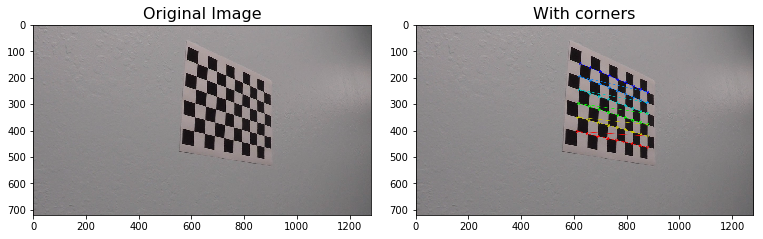

In [5]:
#Display orignal and corner images of the read image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=16)
cv2.drawChessboardCorners(img, (9, 6), corners, ret)
ax2.imshow(img)
ax2.set_title('With corners', fontsize=16)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Use the object points and the image points to calibrate the camera

In [6]:
#Take the last calibration image as reference image
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

Create the pipeline function for undistort images using the calibration camera parameters.

In [7]:
def undistortImg(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

Test the undistorsion function

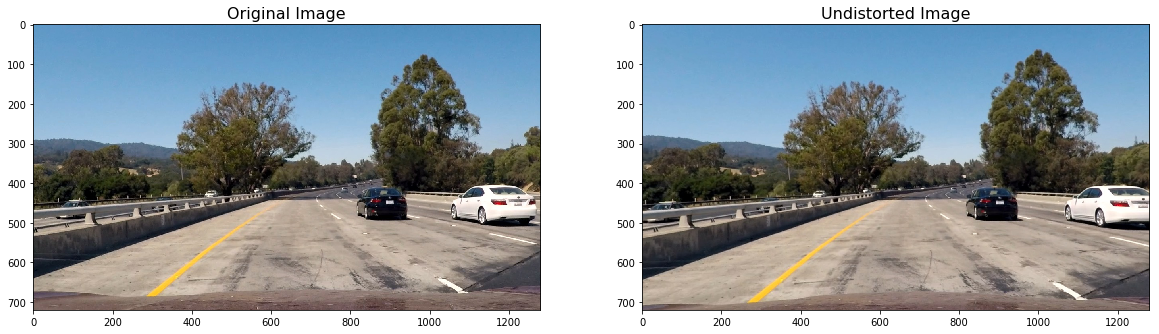

In [8]:
#Take test1.jpg image as reference image
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Pipeline: Get the undistorted images
dst = undistortImg(img, mtx, dist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=16)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=16)
img_size = (img.shape[1], img.shape[0])

## 2. Perpective transformation

In order to change the perpesctive of a image, the source and destination area should be defined:

In [9]:
#Take test1.jpg image as reference image
img = cv2.imread('test_images/test1.jpg')

#Get the shape from the image
imshape = np.array(img).shape
    
#Define the points of the source area
srcPointDownLeft  = [ int(imshape[1]*0.15),  int(imshape[0]*0.95) ]
srcPointUpLeft    = [ int(imshape[1]*0.40),  int(imshape[0]*0.65) ]

srcPointDownRight = [ int(imshape[1]*0.90),  int(imshape[0])*0.95]
srcPointUpRight   = [ int(imshape[1]*0.60),  int(imshape[0]*0.65) ]
    
#Define the source area 
src = np.float32([srcPointDownLeft, srcPointUpLeft, srcPointUpRight, srcPointDownRight])
       
#Define the points of the destination area
destPointDownLeft  = [ int(imshape[1]*0.24),  int(imshape[0]*0.95)]
destPointUpLeft    = [ int(imshape[1]*0.07),  int(imshape[0]*0.0)]

destPointDownRight = [ int(imshape[1]*0.85),  int(imshape[0])*0.95]
destPointUpRight   = [ int(imshape[1]*0.96),  int(imshape[0]*0.0)]

#Define the dest area 
dst = np.float32([destPointDownLeft, destPointUpLeft, destPointUpRight, destPointDownRight])

Create the pipeline function for get a bird eye perspective using the source and destination area defined before

In [10]:
def birdEye(img, src, dst): 
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src , dst)
    
    # Given src and dst points, calculate the inverse perspective transform matrix
    Mi = cv2.getPerspectiveTransform(dst, src )
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M, Mi

Test the birdEye function using the test images. The red polygon is the source area while the green one is the destination area. The values of the source and destination polygon were chosen manually and verified with the straight lane lines test image (first 2 images).

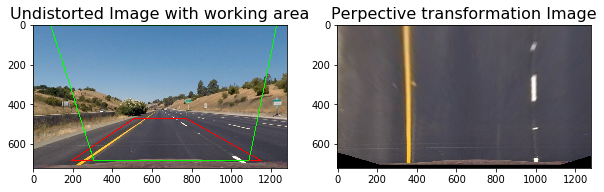

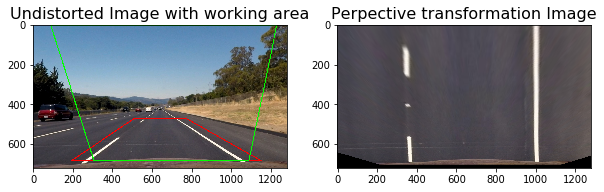

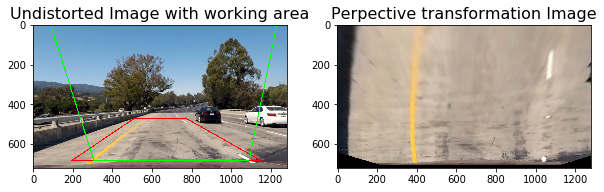

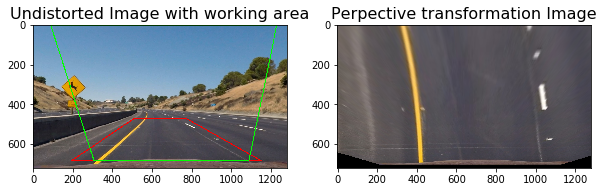

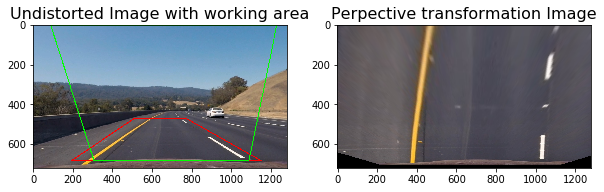

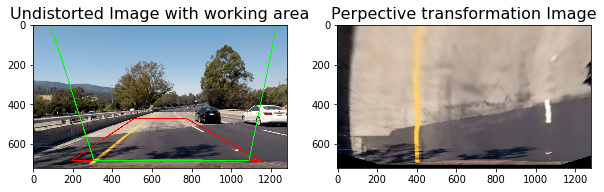

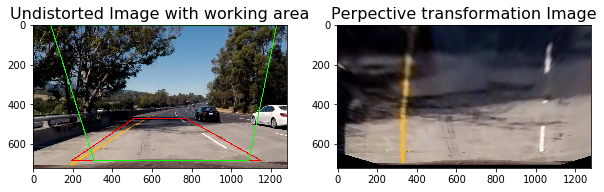

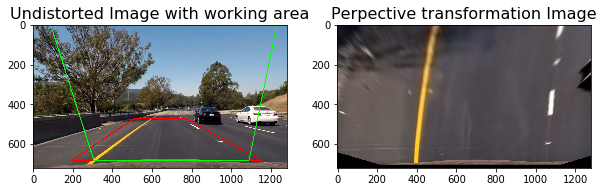

In [11]:
images = glob.glob('test_images/straight_lines*.jpg')
images = images +  glob.glob('test_images/test*.jpg')

imgs = []
imgsWarped = []

for idx, fname in enumerate(images):
    
    #Read image and transform to RGB
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(img)
        
    #Pipeline: Get the perspective transformation of the undistorted images
    img = undistortImg(img, mtx, dist)
    imgWarped, M, Mi = birdEye(img, src, dst)
    imgsWarped.append(imgWarped)

    #Create a image with the work and destination area highlighted
    pts = src.reshape((-1,1,2))
    pts = np.array(pts, np.int32)
    cv2.polylines(img,[pts],True,(255,0,0), 3) 

    pts = dst.reshape((-1,1,2))
    pts = np.array(pts, np.int32)
    cv2.polylines(img,[pts],True,(0,255,0), 3) 

    #display origianl and transformation images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))                                           
    ax1.imshow(img)
    ax1.set_title('Undistorted Image with working area', fontsize=16)
    ax2.imshow(imgWarped)
    ax2.set_title('Perpective transformation Image', fontsize=16)   
    

## 3. Threshold and color filtering

### 3.1 HLS color filtering 

The HLSFilter function will mask the image based on a HLS space color depending on the minimum and maximum thresholds set as parameter of the function. 
The function returns the masked images, masked HLS channels and the  HLS channels.

In [12]:
def HLSFilter(img, min_thresh=(0, 20, 30), max_thresh=(50, 170, 255)):
    
    #Copy the images
    img = np.copy(img)
    
    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    #Get channels
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    #Apply saturation thershold
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= min_thresh[2]) & (s_channel <= max_thresh[2])] = 1
    
    #Apply hue threshold 
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= min_thresh[0]) & (h_channel <= max_thresh[0])] = 1
    
    #Apply hue threshold 
    l_binary = np.zeros_like(h_channel)
    l_binary[(l_channel >= min_thresh[1]) & (l_channel <= max_thresh[1])] = 1
    
    #Combined the 2 binaries
    combined = np.zeros_like(s_channel)
    combined[(l_binary==1) & (s_binary==1) & (h_binary==1) ] = 1
    
    return combined, (h_channel, l_channel, s_channel, h_binary, l_binary, s_binary)

In following cell, the descomposition of in HLS channels for every images is shown. Looking at the saturated channel is evident that is easy to get the yellow color from this channel. However, in those images with shades the saturation channel is not enough to recognizes properly the yellow line (7th image). But the hue channel could be used to removed from the image the shades. By the other hand the white color, it is observed that the white color can be easly identified using the L channel. 

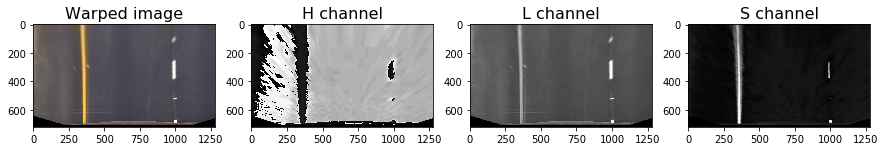

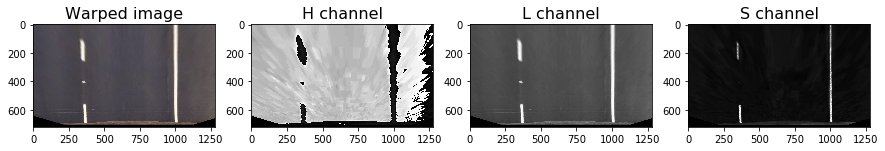

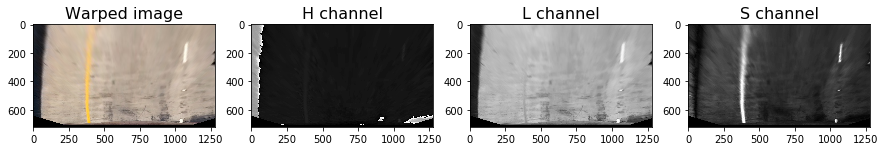

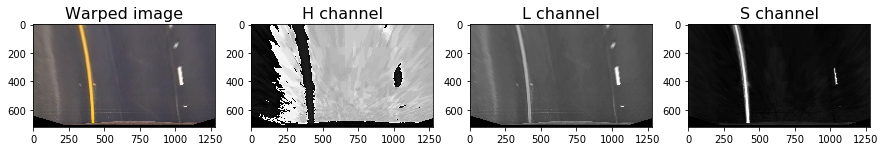

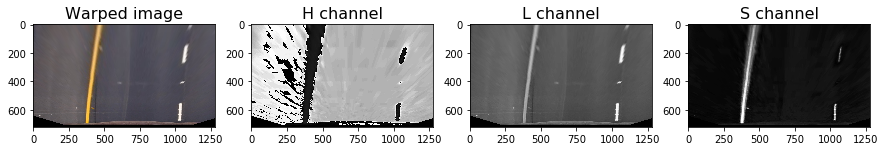

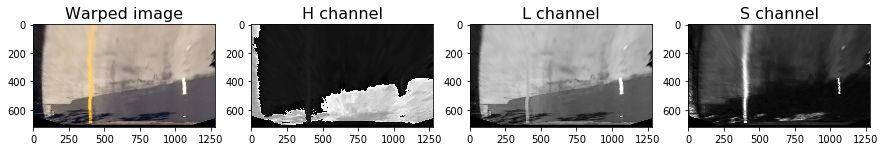

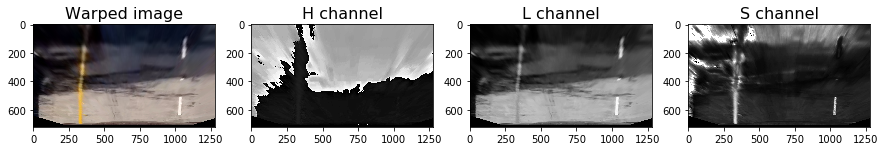

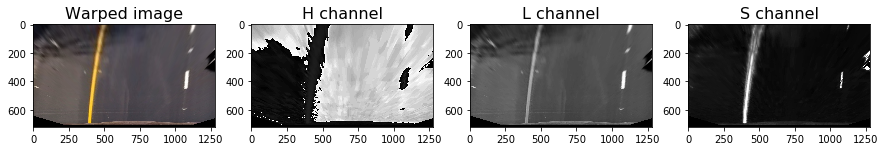

In [13]:
#Pipeline: Get the perspective transformation of the undistorted images
img = undistortImg(imgs[4], mtx, dist)
imgWarped, M, Mi = birdEye(img, src, dst)


for imgWarped in imgsWarped:
    imgColor, imDesc = HLSFilter(imgWarped)
    
    #display transformation images and color filter
    f, axarr = plt.subplots(1, 4, figsize=(15,10))                                           
    
    axarr[0].imshow(imgWarped)
    axarr[0].set_title('Warped image', fontsize=16)

    axarr[1].imshow(imDesc[0], cmap='gray')
    axarr[1].set_title('H channel', fontsize=16)

    axarr[2].imshow(imDesc[1], cmap='gray')
    axarr[2].set_title('L channel', fontsize=16)

    axarr[3].imshow(imDesc[2], cmap='gray')
    axarr[3].set_title('S channel', fontsize=16) 
    
    

The thresholds for the white mask are defined using only the L channel. By the other hand, as explained above, the thresholds for the yellow mask are defined using the H and S channel. An important annotation is that the sensitivity for the white mask could not be set higher than 45, otherwise al lot of noise will not be filtered in the images with high light density (images 3rd and 6th).

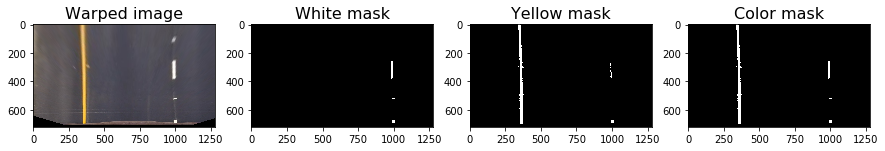

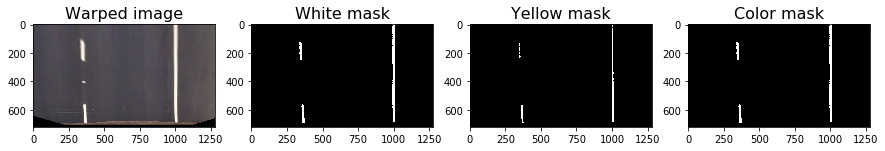

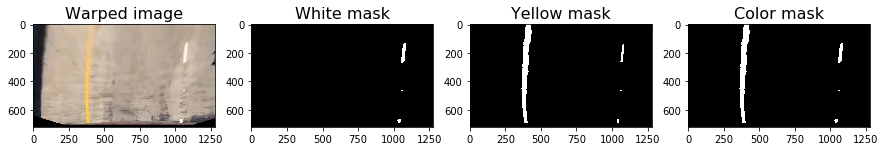

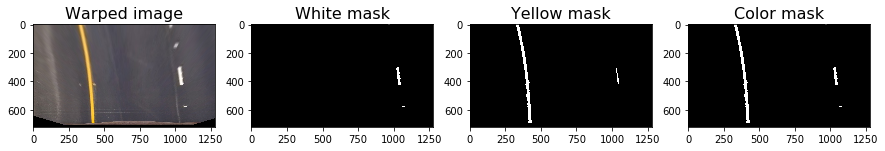

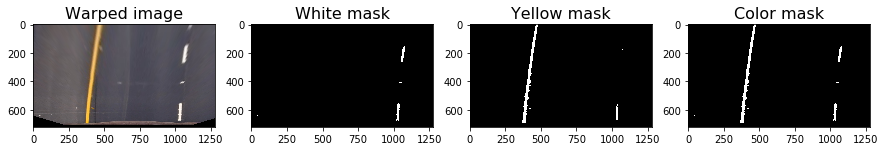

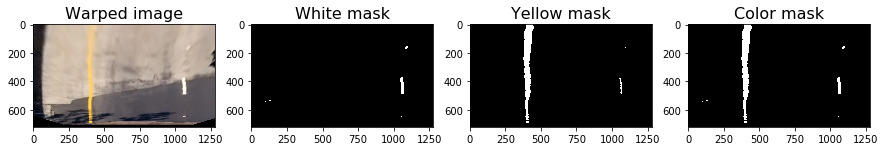

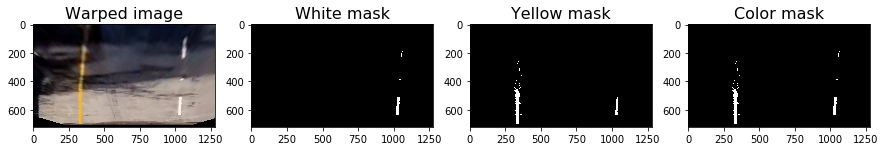

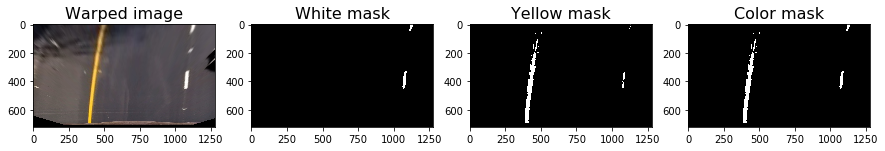

In [14]:
#Color mask 
sensitivity = 45 
WhiteLowMask  = [ 0, 255-sensitivity, 0]
WhiteHighMask = [255, 255, 255]

#yellow mask 
sensitivity = 125 
YellowLowMask  = [ 0, 50, 255-sensitivity]
YellowHighMask = [100, 255, 255]

for img in imgs:
    
    #Pipeline: Get the perspective transformation of the undistorted images and apply color filter
    img = undistortImg(img, mtx, dist)
    imgWarped, M, Mi = birdEye(img, src, dst)
    imgWhiteMask, imgWhiteDesc = HLSFilter(imgWarped, WhiteLowMask, WhiteHighMask)
    imgYellowMask, imgYellowDesc = HLSFilter(imgWarped, YellowLowMask, YellowHighMask)
    
    def CombMask(mask_1, mask_2):
        comb = np.zeros_like(mask_1)
        comb[(mask_1 == 1) | (mask_2 == 1)] = 1
        return comb
    
    ImgMask = CombMask(imgWhiteMask, imgYellowMask)
    
    #display transformation images and color filter
    f, axarr = plt.subplots(1, 4, figsize=(15,5))                                           
    
    axarr[0].imshow(imgWarped)
    axarr[0].set_title('Warped image', fontsize=16)
    
    axarr[1].imshow(imgWhiteMask, cmap='gray')
    axarr[1].set_title('White mask', fontsize=16)
    
    axarr[2].imshow(imgYellowMask, cmap='gray')
    axarr[2].set_title('Yellow mask', fontsize=16)
    
    axarr[3].imshow(ImgMask, cmap='gray')
    axarr[3].set_title('Color mask', fontsize=16)

### 3.2 Sobel threslhold

The function absSobelThresh will apply the sobel operator on the image. The parameters are the kernel size anf the threshold.

In [15]:
def absSobelThresh(img, orient='x', sobel_kernel=5, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # Return the result
    return binary_output

The sobel operation is applied in the X orientantion as the lines searched are vertical. However the improvement given by the sobel mask is reduced compare with the color mask. to have into account that if the low and high thresholds are not chosen correctly, a lot of noise will pass to the final mask images, producing  errors in the curvature calculation.

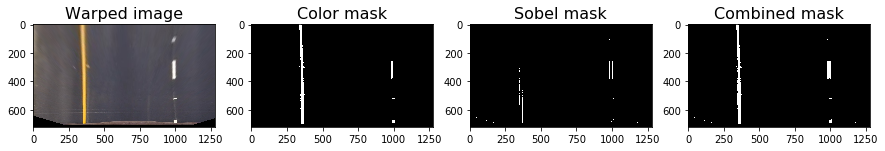

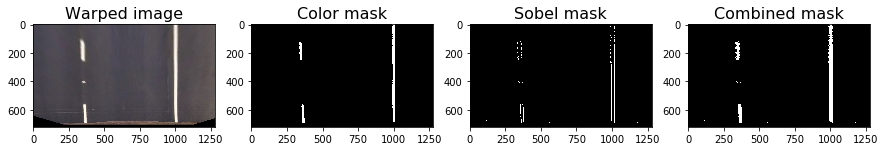

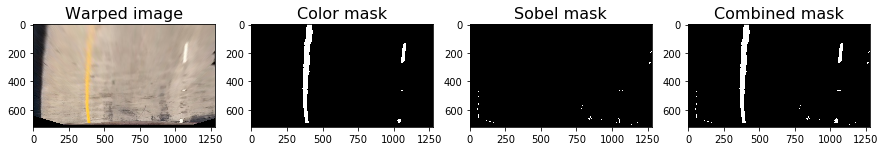

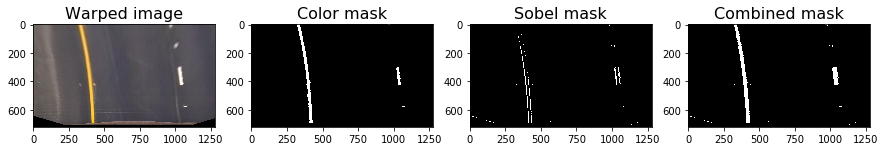

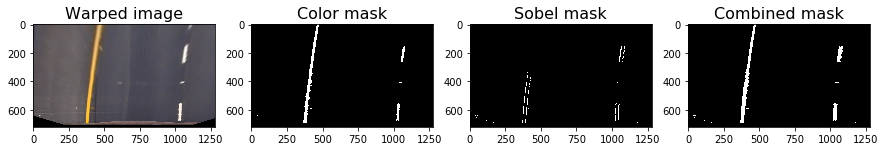

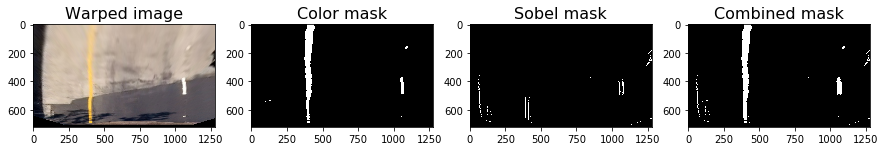

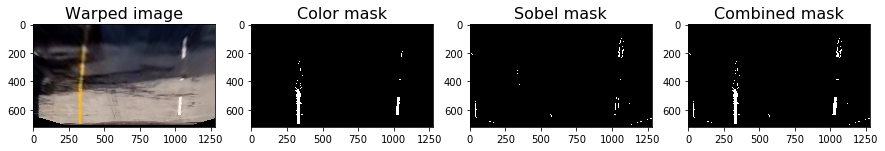

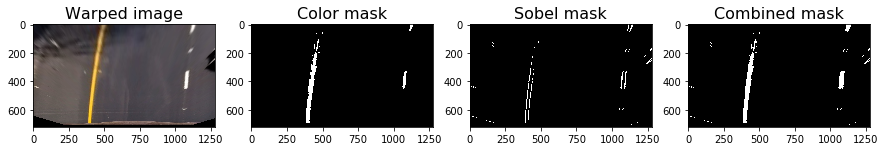

In [16]:
threshVal = (50, 250)

idx = 0
ImgsMask = []

for img in imgs:
    
    #Pipeline: Get the perspective transformation of the undistorted images 
    img = undistortImg(img, mtx, dist)
    imgWarped, M, Mi = birdEye(img, src, dst)
    
    #Color Mask
    imgWhiteMask, imgWhiteDesc = HLSFilter(imgWarped, WhiteLowMask, WhiteHighMask)
    imgYellowMask, imgYellowDesc = HLSFilter(imgWarped, YellowLowMask, YellowHighMask)  
    ImgColorMask = CombMask(imgWhiteMask, imgYellowMask)
    
    #Sobel Mask
    ImgSobelMask = absSobelThresh(imgWarped, orient='x', thresh = threshVal)
    #Combined
    ImgMask = CombMask(ImgSobelMask, ImgColorMask)
    ImgsMask.append(ImgMask)
    
    #Save images
    cv2.imwrite("./output_images/ImgMask"+ str(idx) + ".png", 255*ImgMask)
    idx=idx+1
    
    #display transformation images and color filter
    f, axarr = plt.subplots(1, 4, figsize=(15,5))                                           
    
    axarr[0].imshow(imgWarped)
    axarr[0].set_title('Warped image', fontsize=16)
    
    axarr[1].imshow(ImgColorMask, cmap='gray')
    axarr[1].set_title('Color mask', fontsize=16)
    
    axarr[2].imshow(ImgSobelMask, cmap='gray')
    axarr[2].set_title('Sobel mask', fontsize=16)
                          
    axarr[3].imshow(ImgMask, cmap='gray')
    axarr[3].set_title('Combined mask', fontsize=16)

## 4 Finding the lines and calculate the curvature

### 4.1 Measuring the curvature and offset

The curvMeasuring function calculates the curvature giving the coordinates: y and x. The maths of this function are fin in this [link](http://www.intmath.com/applications-differentiation/8-radius-curvature.php). As the x and y coordinates are based into a image that is supposed to be 1260 x 720. To obtain a real value, this coordinates are transform in a real physical space using: *ym_per_pix* and *xm_per_pix*. The values are calculate from the point that the lane is about 30 meters long and 3.7 meters wide. 

In [65]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension


def curvMeasuring(y, x):
    
    # Define y-value where we want radius of curvature
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = 720
       
    if((len(x) > 0) & (len(y) > 0)):
        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    
        # Calculate the new radii of curvature
        curveRad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
               
        return curveRad
    else:
        return 0

In the following cell the curvMeasuring measuring courve will be test using some fake data.

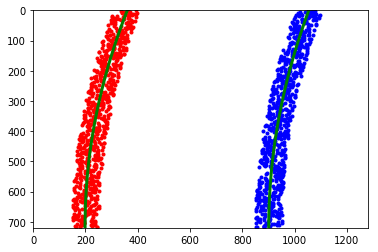

In [66]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [67]:
left_curverad = curvMeasuring(ploty, leftx)
right_curverad = curvMeasuring(ploty, rightx)

print("Left curve radio:", left_curverad, 'm', "\nRight curve radio: ", right_curverad, 'm')
print("Left init:", left_init, 'm', "\nRight init: ", right_init, 'm')

Left curve radio: 514.943402143 m 
Right curve radio:  550.980558204 m
Left init: 462.25178213 m 
Right init:  452.468070032 m


The vehicle offset is calculate using the the polynomial evaluate at the bottom for the left and right line. And calculating the offset of its center to the center of the image.

In [68]:
def vehOffset(left_fit, right_fit):
    
    ploty = 720
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    offset = (right_fitx - left_fitx)/2 +left_fitx
    offset = offset*xm_per_pix
    offset = 640*xm_per_pix - offset
    
    return offset


In [69]:
offset = vehOffset(left_fit, right_fit)
print("Vehicle offset: ", offset, "m")

Vehicle offset:  0.476073637074 m


### 4.2 Finding the lines on the first frame (blind search)

To find the lines in the images there are 2 algorithms that could be applied. The blind search that is used on the first frame of the video and the nonìblind search that is used after the first 2 lines are identified. I this chapeter is explained the algorithm of the blind search.

#### 4.2.1 Histogram and base points

The first step is to identify the base point of the lines. To do this, an histogram of the lower part of the images is calculate and the maxium points of the 2 verticals half are identified. These 2 points are the baseìpoints for the left and right lines. From this point the second part of the algorithm will start.

In [70]:
PLOT = 1

def basePoints(img):
    
    midpoint = int(img.shape[0]/2)
    #Create a histogram of the lower half of the image
    histogram = np.sum(img[500:,:], axis=0)
    
    #Find the base points by finding the max value on the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
    return leftx_base, rightx_base, histogram

Note that the error in the base points will increase with the area of the lower part. Take for instance the image right line of the 4th images. if the area chosen is *y = [400, 720]* the base point will be around *1110* but if the area is *y =[500, 720]*, the base point will be around *1130*. However as smaller the area the chances to find a line in that are decrease, giving as result non basepoints to start the algorithm.

Mean Inte Lane distance:  659.875


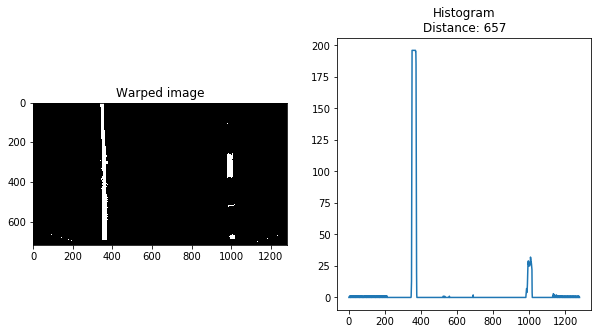

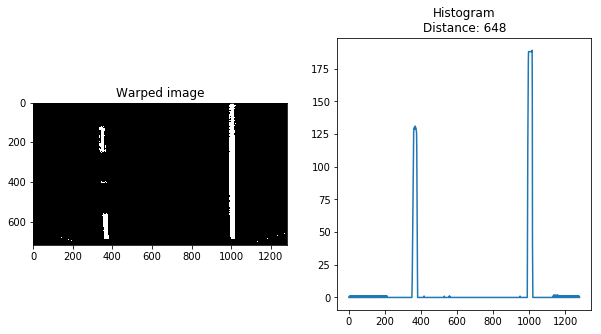

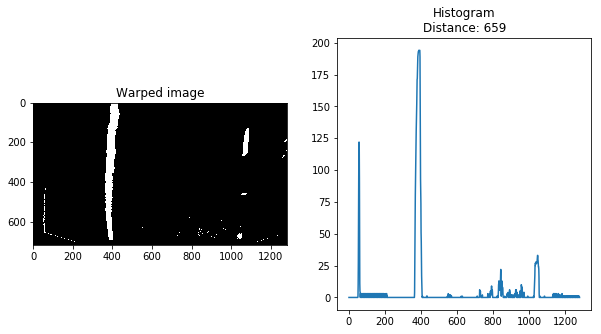

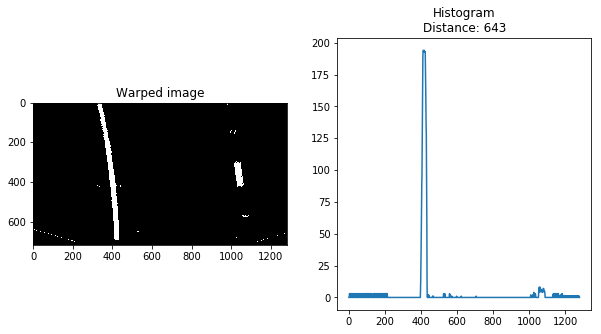

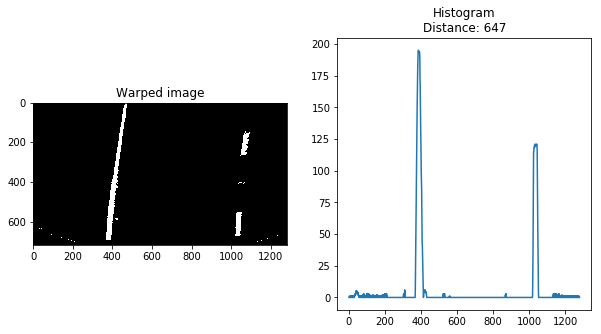

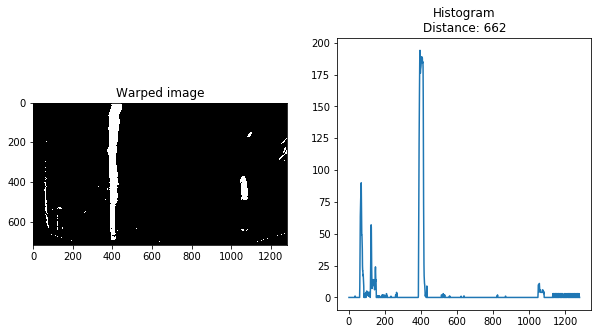

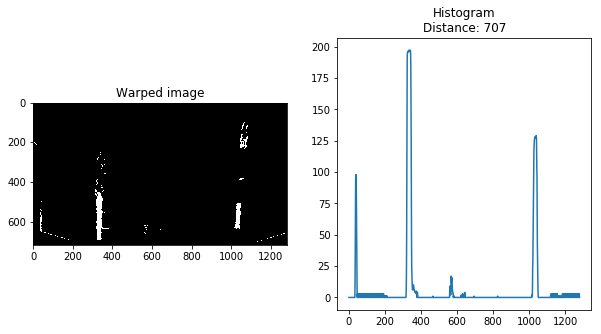

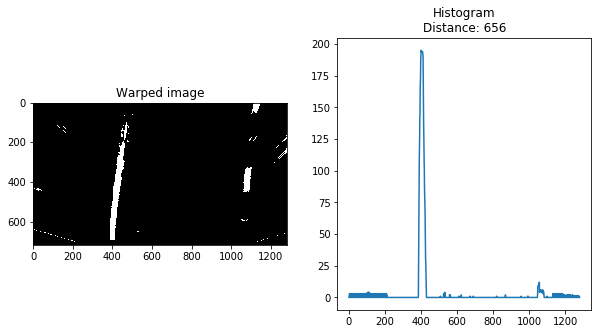

In [71]:
interLaneDistance = 0

for imgMask in ImgsMask:
    
    img = np.array(imgMask)
    leftx_base, rightx_base,  histogram = basePoints(img)
    
    interLaneDistance += (rightx_base - leftx_base)

    f, axarr = plt.subplots(1, 2, figsize=(10,5))
        
    axarr[0].imshow(img, cmap='gray')
    axarr[0].set_title('Warped image', fontsize=12)
    
    axarr[1].plot(histogram)
    title = "".join(['Histogram\n', 'Distance: ', str(rightx_base - leftx_base)])
    axarr[1].set_title(title, fontsize=12)

interLaneDistance = interLaneDistance/len(ImgsMask) 

print("Mean Inte Lane distance: ", interLaneDistance)

#### 4.2.2 Fit the polynomial

From the basepoint calculated, a sliding window algorithm is used to go up the end of line and fit the polynomial. The algorithm set a windown in the base-points and save the points inside the window. The window is slided up and recentered. The window is recentered only if a minimum number of pixels are found inside the window. The window is centered to the mean of the pixels inside the window. Again, the pixel inside the window are saved. Once the window has reached the top of the image, the points saved in each iteration are used to fit a polynomial. 

There are 3 parameters to calibrate: *number of windows*, *minimum pixel number to recenter the window* and the *margin*. The margin is useful to filter the noise left by the sobel and color mask If the margin is too high, the noise beside the lines will affect the curvature calculation.

In [72]:
def fitLineInitPolynomial(img, margin):
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Search for base points
    leftx_base, rightx_base,  histogram = basePoints(img)
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
      
    # Set minimum number of pixels found to recenter window
    minpix = 40
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4)
       
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    #Caculare the curvature radius
    left_curveRad = curvMeasuring(lefty, leftx)
    right_curveRad = curvMeasuring(righty, rightx)
    
    #initializes the polynomial array
    left_fit = np.array([0,0,0])
    right_fit = np.array([0,0,0])
    
    #Check for the size of the array to avoid errors
    if((leftx.size>0) & (lefty.size>0)):
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)   
    
    #Check for the size of the array to avoid errors
    if((rightx.size>0) & (righty.size>0)):
        # Fit a second order polynomial to each
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_curveRad, right_curveRad,  out_img, (leftx, lefty, rightx, righty)
   

Applying the sliding algorithm and calculating the curvature to each figure it is observed that the polynomial and the curvature is higly sensitive to lightly changes of the curve. Only in 3 of the 8 test images its observed a coherent value between right and left.

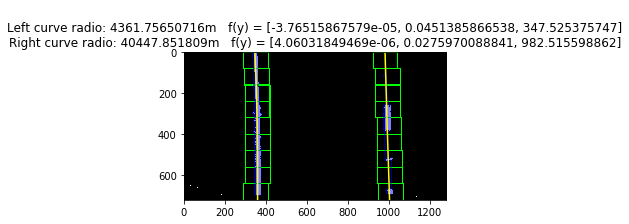

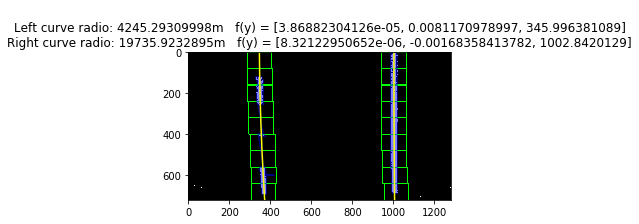

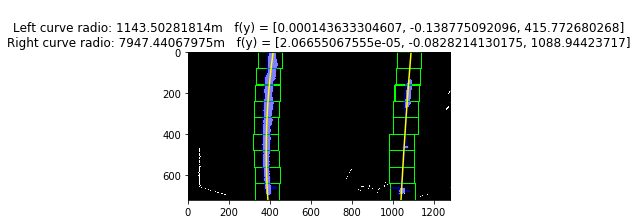

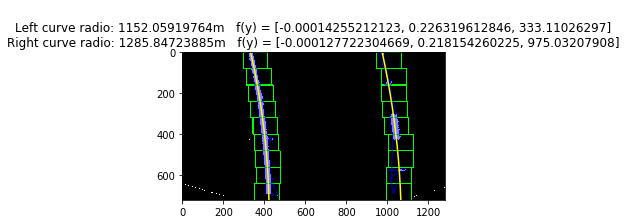

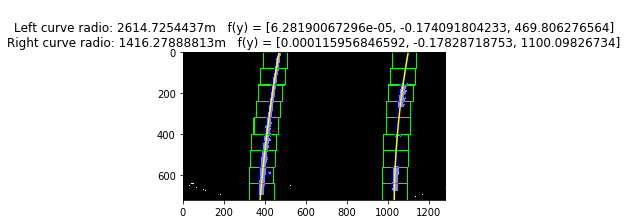

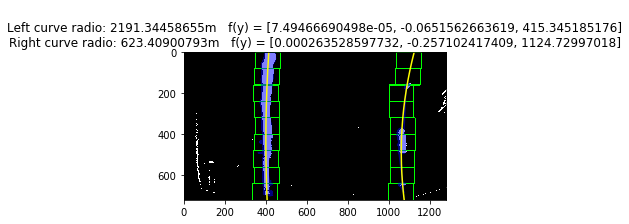

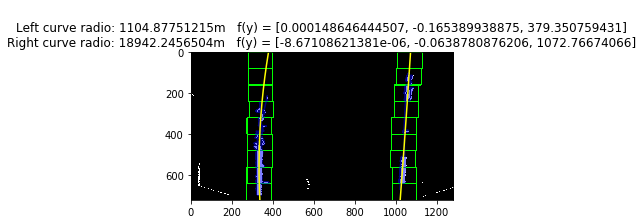

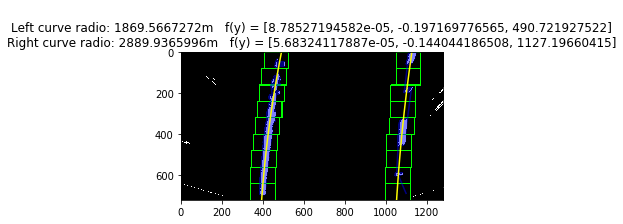

In [73]:
margin = 60

for img in ImgsMask:
    left_fit_init, right_fit_init, left_curveRad, right_curveRad, out_img, nonzero = fitLineInitPolynomial(img, margin)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )

    left_fitx = left_fit_init[0]*ploty**2 + left_fit_init[1]*ploty + left_fit_init[2]
    right_fitx = right_fit_init[0]*ploty**2 + right_fit_init[1]*ploty + right_fit_init[2]
    #right_fitx = right_fit_init[0]*ploty**2 + right_fit_init[1]*ploty + right_fit_init[2]
    
    f, axarr = plt.subplots(1, 1, figsize=(4.7,6))
    axarr.imshow(out_img)
    axarr.plot(nonzero[0], nonzero[1], color='blue', alpha=0.5)
    axarr.plot(nonzero[2], nonzero[3], color='blue', alpha=0.5)
    axarr.plot(left_fitx, ploty, color='yellow')
    axarr.plot(right_fitx, ploty, color='yellow')
    text = "".join(["\nLeft curve radio: ", str(left_curveRad), 'm', "   f(y) = [", str(left_fit_init[0]), ", ", str(left_fit_init[1]), ", ", str(left_fit_init[2]), "]" ])
    text = "".join([text, "\nRight curve radio: ", str(right_curveRad), 'm',"   f(y) = [", str(right_fit_init[0]), ", ", str(right_fit_init[1]), ", ", str(right_fit_init[2]), "]" ])
    axarr.set_title(text, fontsize=12)

    #print("Left curve radio:", left_curveRad, 'm', "\nRight curve radio: ", right_curveRad, 'm\n')

### 4.3 Finding the lines after the first frame (non blind search)

The non-blind search algorith is similar to the one explained above, but instead of multiple windows. a single strip center in the last polynomial is used. The strip has a width (or margin) determinate by a parameter. All the points inside the strip are saved to calculate a new polynomial.

In [74]:
def fitLinePolynomial(img, left_fit, right_fit, margin = 100):
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
      
    #Caculare the curvature radius
    left_curveRad = curvMeasuring(lefty, leftx)
    right_curveRad = curvMeasuring(righty, rightx)
    
    #initializes the polynomial array
    left_fit = np.array([0,0,0])
    right_fit = np.array([0,0,0])
    
    #Check for the size of the array to avoid errors
    if((leftx.size>0) & (lefty.size>0)):
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)   
    
    #Check for the size of the array to avoid errors
    if((rightx.size>0) & (righty.size>0)):
        # Fit a second order polynomial to each
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_curveRad, right_curveRad, (leftx, lefty, rightx, righty)
   

The algorthim is validated calculating the polynomial with the blind search and with the non-blind search.

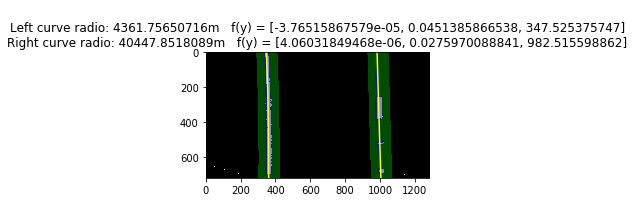

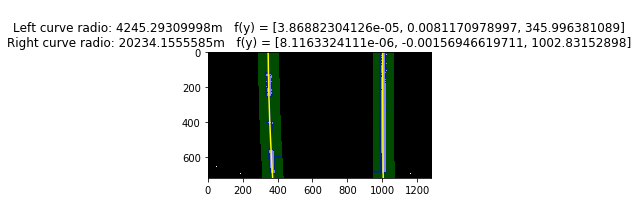

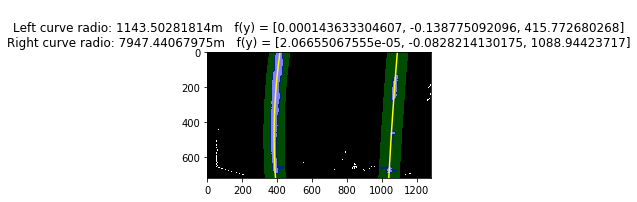

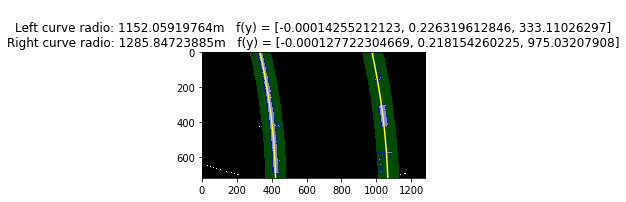

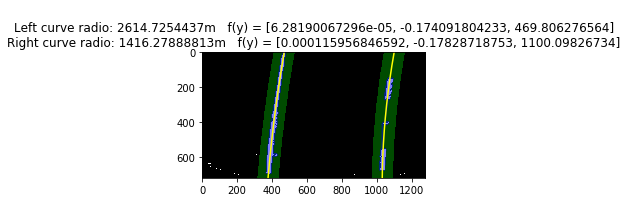

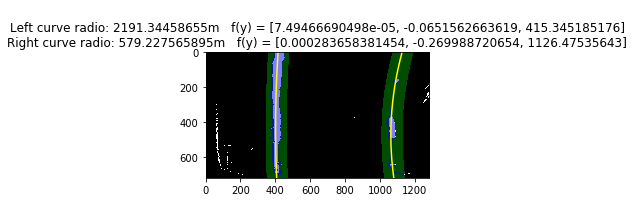

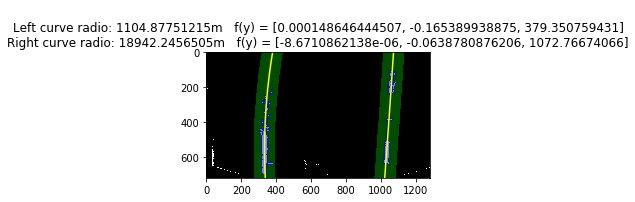

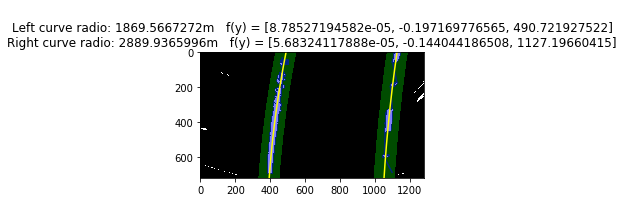

In [75]:
for img in ImgsMask:
    margin = 60
    left_fit_init, right_fit_init, left_curveRad, right_curveRad, out_img, nonzero = fitLineInitPolynomial(img, margin)
    left_fit, right_fit, left_curveRad, right_curveRad, nonzero = fitLinePolynomial(img, left_fit_init, right_fit_init, margin)

    #print("Left curve radio:", left_curveRad, 'm', "\nRight curve radio: ", right_curveRad, 'm')

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
                                                                    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
                                                                    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    f, axarr = plt.subplots(1, 1, figsize=(4,5))
    axarr.imshow(result)
    axarr.plot(nonzero[0], nonzero[1], color='blue', alpha=0.5)
    axarr.plot(nonzero[2], nonzero[3], color='blue', alpha=0.5)
    axarr.plot(left_fitx, ploty, color='yellow')
    axarr.plot(right_fitx, ploty, color='yellow') 
    text = "".join(["\nLeft curve radio: ", str(left_curveRad), 'm', "   f(y) = [", str(left_fit[0]), ", ", str(left_fit[1]), ", ", str(left_fit[2]), "]" ])
    text = "".join([text, "\nRight curve radio: ", str(right_curveRad), 'm',"   f(y) = [", str(right_fit[0]), ", ", str(right_fit[1]), ", ", str(right_fit[2]), "]" ])
    axarr.set_title(text, fontsize=12)
                                                                    

## 5 Drawing

The area inside the 2 lines is drawn in a fake warped image and after using the perspective inverse matrix to print in the original image.

In [77]:
def drawing(img, warped, Minv, left_fit, right_fit, no_error):
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    pts = np.array(pts, np.int32)

    # Draw the lane onto the warped blank image
    if(no_error):
        color = (0, 255, 0)
    else:
        color = (255, 0, 0)
    
    cv2.fillPoly(warp_zero, pts, color)
    #plt.imshow(warp_zero)  

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_zero, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return result
      

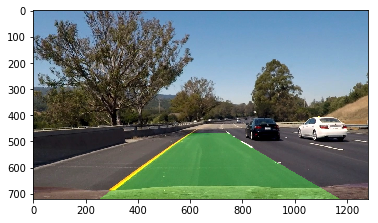

In [78]:
img = drawing(imgs[-1], imgsWarped[-1], Mi, left_fit, right_fit, True)

plt.imshow(img)  

## 6. Pipeline

Build the pipeline with all the function used to process the image.

In [79]:
def pipeline(img):
    
    # Unditort image
    imgUndist = undistortImg(img, mtx, dist)
    
    #Apply perpective transformation
    imgWarped, M, Mi = birdEye(imgUndist, src, dst)
    
    #Apply color mask
    imgWhiteMask, imgWhiteDesc = HLSFilter(imgWarped, WhiteLowMask, WhiteHighMask)
    imgYellowMask, imgYellowDesc = HLSFilter(imgWarped, YellowLowMask, YellowHighMask)  
    ImgColorMask = CombMask(imgWhiteMask, imgYellowMask)
    
    #Apply Sobbel mask
    ImgSobelMask = absSobelThresh(imgWarped, orient='x', thresh = threshVal)
    ImgMask = CombMask(ImgSobelMask, ImgColorMask)
    
    #Fit polynomial
    left_fit, right_fit, left_curveRad, right_curveRad, out_img, nonzero = fitLineInitPolynomial(ImgMask, margin)
    
    #Calculate offset
    offset = vehOffset(left_fit, right_fit)
    
    #Draw the area
    result = drawing(imgUndist, imgWarped, Mi, left_fit, right_fit, True)
    
    #print curvature in image
    text = "".join(["Left curve radio:", str(left_curveRad), 'm'])
    cv2.putText(result,text,(10,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
    text = "".join([ "Right curve radio: ", str(right_curveRad), 'm'])
    cv2.putText(result,text,(10,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
    text = "".join([ "Offset: ", str(offset), 'm'])
    cv2.putText(result,text,(10,150), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
    
    return result
    

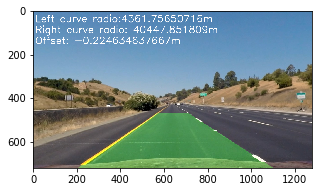

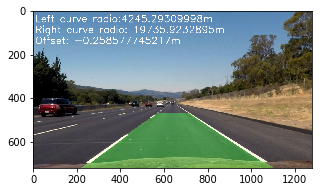

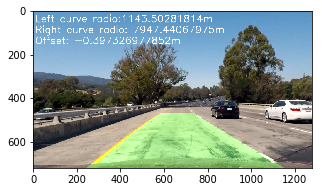

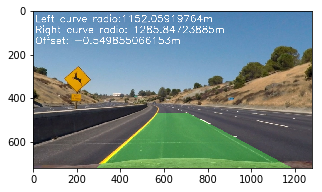

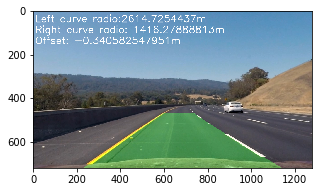

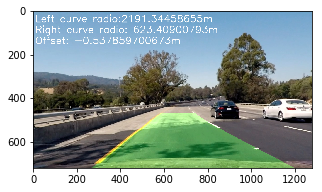

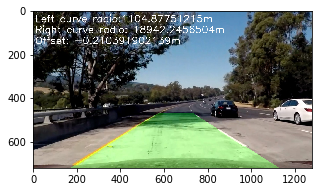

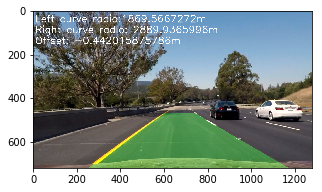

In [80]:
results = []

for img in imgs:
    
    #Pipeline: Get the perspective transformation of the undistorted images 
    result = pipeline(img)
    
    #display transformation images and color filter
    f, axarr = plt.subplots(1, 1, figsize=(5,5))                                           
    
    axarr.imshow(result)

## 7. Video processing

In [81]:
from moviepy.editor import VideoFileClip

In [82]:
clip_output = 'test_videos_output/AdvanceLanDetection.mp4'

clip = VideoFileClip("project_video.mp4")
#clip = clip.fl_image(pipeline).subclip(0,10)
clip = clip.fl_image(pipeline)
%time clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/AdvanceLanDetection.mp4
[MoviePy] Writing video test_videos_output/AdvanceLanDetection.mp4


100%|█████████▉| 1260/1261 [04:09<00:00,  5.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/AdvanceLanDetection.mp4 

CPU times: user 4min 52s, sys: 2.77 s, total: 4min 55s
Wall time: 4min 10s


## 8. Pipeline plus

Build the pipeline with the track function and with the sanity check.

### 8.1 Line class definition

Define the class Line to be use during the video processing. The class provide methods to save its current status depending if the line is detected or not, and to access its internal data (Java style, not need for it). When the setting the current satus the Line class will save a filter value of the curvature and the fit.

In [85]:
class Line():       
    def __init__(self):

        # was the line detected in the last iteration?
        self.detected = False    
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.array([0,0,0])  
        #polynomial coefficients for the most recent fit
        self.current_fit = np.array([0,0,0]) 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #Curvatures of the last n iterations
        self.cuvature_log = []
    
    def setCurrentSts(self, currentFit, curvature):
               
        #If the Line is already detected
        if(self.detected == True):
            #Save the current fit and the difference with the last one.
            self.diffs = currentFit - self.current_fit 
            self.current_fit = currentFit
            #Save the best fit and curvature as the average of the 2 last samples.
            self.best_fit = (self.best_fit + currentFit)/2
            self.radius_of_curvature = (self.radius_of_curvature + curvature)/2
        else:
            #Save the data for first time 
            self.current_fit = currentFit
            self.best_fit = currentFit
            self.radius_of_curvature = curvature
        
        #Log the curvatures
        self.cuvature_log.append(self.radius_of_curvature)
        
        #Set detected as True
        self.detected = True
    
    def getDetected(self):
        return self.detected
    
    def getBestFit(self):
        return self.best_fit
    
    def getCurvature(self):
        return self.radius_of_curvature
    
    def getCurvatureLog(self):
        return self.cuvature_log
        

### 8.2 Sanity check

The function will check that the 2 lines are parallel. It will take around 6 check points and calculate the distance netween the 2 lines. If the mean of the distance is not with in 5% of the average distance, it will consider as not parallel.

In [86]:
def CheckParallel(img, left_fit, right_fit):
        
    #ImageDimenstion
    imgDim = np.array(img).shape
    
    #The points to check
    pts = np.array(range(0, imgDim[1], 100))
    
    #Initializes the result points
    leftPtsX = np.array(pts)
    rightPtsX = np.array(pts)
    
    #Calculate the the x in the check points
    for pt in range(len(pts)):
        leftPtsX[pt] = left_fit[0]*pts[pt]**2 + left_fit[1]*pts[pt] + left_fit[2]      
        rightPtsX[pt] = right_fit[0]*pts[pt]**2 + right_fit[1]*pts[pt] + right_fit[2]
    
    #Calculate the mean distance between the check points
    meanDistance = np.mean(rightPtsX - leftPtsX)
    
    #If the mean distance is less than the 5% of the expected one, set the result as not parallel.
    Sens = 0.05
    if((interLaneDistance*(1-Sens) < meanDistance) & (meanDistance < interLaneDistance*(1+Sens))):
        return True
    else:
        return False

The sanity check implements all the function to check the sanity of the calculation.

In [87]:
def SanityCheck(img, left_fit, right_fit, left_curveRad, right_curveRad):
    checkParallelResult = CheckParallel(img, left_fit, right_fit)  
    return checkParallelResult
            

### 8.3 Pipeline plus definition

The pipeline plus implements the sanity check. If the sanity check is not pass for the current image, the Lane status is not saved and the last valid status is used. The area is red if an error is present in the current frame.

In [88]:
L_Line = Line()
R_Line = Line()

def pipelinePlus(img):
       
    # Unditort image
    imgUndist = undistortImg(img, mtx, dist)
    
    #Apply perpective transformation
    imgWarped, M, Mi = birdEye(imgUndist, src, dst)
    
    #Apply color mask
    imgWhiteMask, imgWhiteDesc = HLSFilter(imgWarped, WhiteLowMask, WhiteHighMask)
    imgYellowMask, imgYellowDesc = HLSFilter(imgWarped, YellowLowMask, YellowHighMask)  
    ImgColorMask = CombMask(imgWhiteMask, imgYellowMask)
    
    #Apply Sobbel mask
    ImgSobelMask = absSobelThresh(imgWarped, orient='x', thresh = threshVal)
    ImgMask = CombMask(ImgSobelMask, ImgColorMask)
    
    #Fit polynomial
    if(L_Line.getDetected() == False | R_Line.getDetected() == False):
        
        #Use the blind search if it is the first time 
        left_fit, right_fit, left_curveRad, right_curveRad, out_img, nonzero = fitLineInitPolynomial(ImgMask, margin)
        #Sanity is always True the first time
        sanity = True
            
    else:
        #Use the the non-blind seach once the line is detected
        
        #Get the best fit from the Line class (filtered)
        left_fit = L_Line.getBestFit()
        right_fit = R_Line.getBestFit()
        
        left_fit, right_fit, left_curveRad, right_curveRad, nonzero = fitLinePolynomial(ImgMask, left_fit, right_fit, margin)
        sanity = SanityCheck(img, left_fit, right_fit, left_curveRad, right_curveRad)
       
    #Save the current status only if the sanity check has passed.
    if(sanity):
        L_Line.setCurrentSts(left_fit, left_curveRad )
        R_Line.setCurrentSts(right_fit, right_curveRad )
    
    #Use the filtered fit to draw the lines
    left_fit = L_Line.getBestFit()
    right_fit = R_Line.getBestFit()
    
    #Calculate offset
    offset = vehOffset(left_fit, right_fit)
    
    #Draw the area
    result = drawing(imgUndist, imgWarped, Mi, left_fit, right_fit, sanity)
    
    #print curvature in image
    left_curveRad = L_Line.getCurvature()
    right_curveRad = R_Line.getCurvature()
    text = "".join(["Left curve radio:", str(left_curveRad), 'm'])
    cv2.putText(result,text,(10,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
    text = "".join([ "Right curve radio: ", str(right_curveRad), 'm'])
    cv2.putText(result,text,(10,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
    text = "".join([ "Offset: ", str(offset), 'm'])
    cv2.putText(result,text,(10,150), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
    
    return result

### 8.4 Video processing with pipeline plus

In [89]:
L_Line = Line()
R_Line = Line()

clip_output = 'test_videos_output/AdvanceLanDetectionPlus.mp4'

clip = VideoFileClip("project_video.mp4")
#clip = clip.fl_image(pipelinePlus).subclip(0,5)
clip = clip.fl_image(pipelinePlus)
%time clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/AdvanceLanDetectionPlus.mp4
[MoviePy] Writing video test_videos_output/AdvanceLanDetectionPlus.mp4


100%|█████████▉| 1260/1261 [03:41<00:00,  5.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/AdvanceLanDetectionPlus.mp4 

CPU times: user 4min 32s, sys: 2.57 s, total: 4min 35s
Wall time: 3min 42s


### 8.5 Curvature log

The curvature log is display to evaluate the curvature calculation. Even if the curvature is already filtered (mean), it is oberved that in some points the change rate does not correspond to the real curvature. Moreover in some parts the differnce between the left and right lane is also a factor of error.

Note that the straight portion of the road is represented in the graph for a increase of both curvatures values.

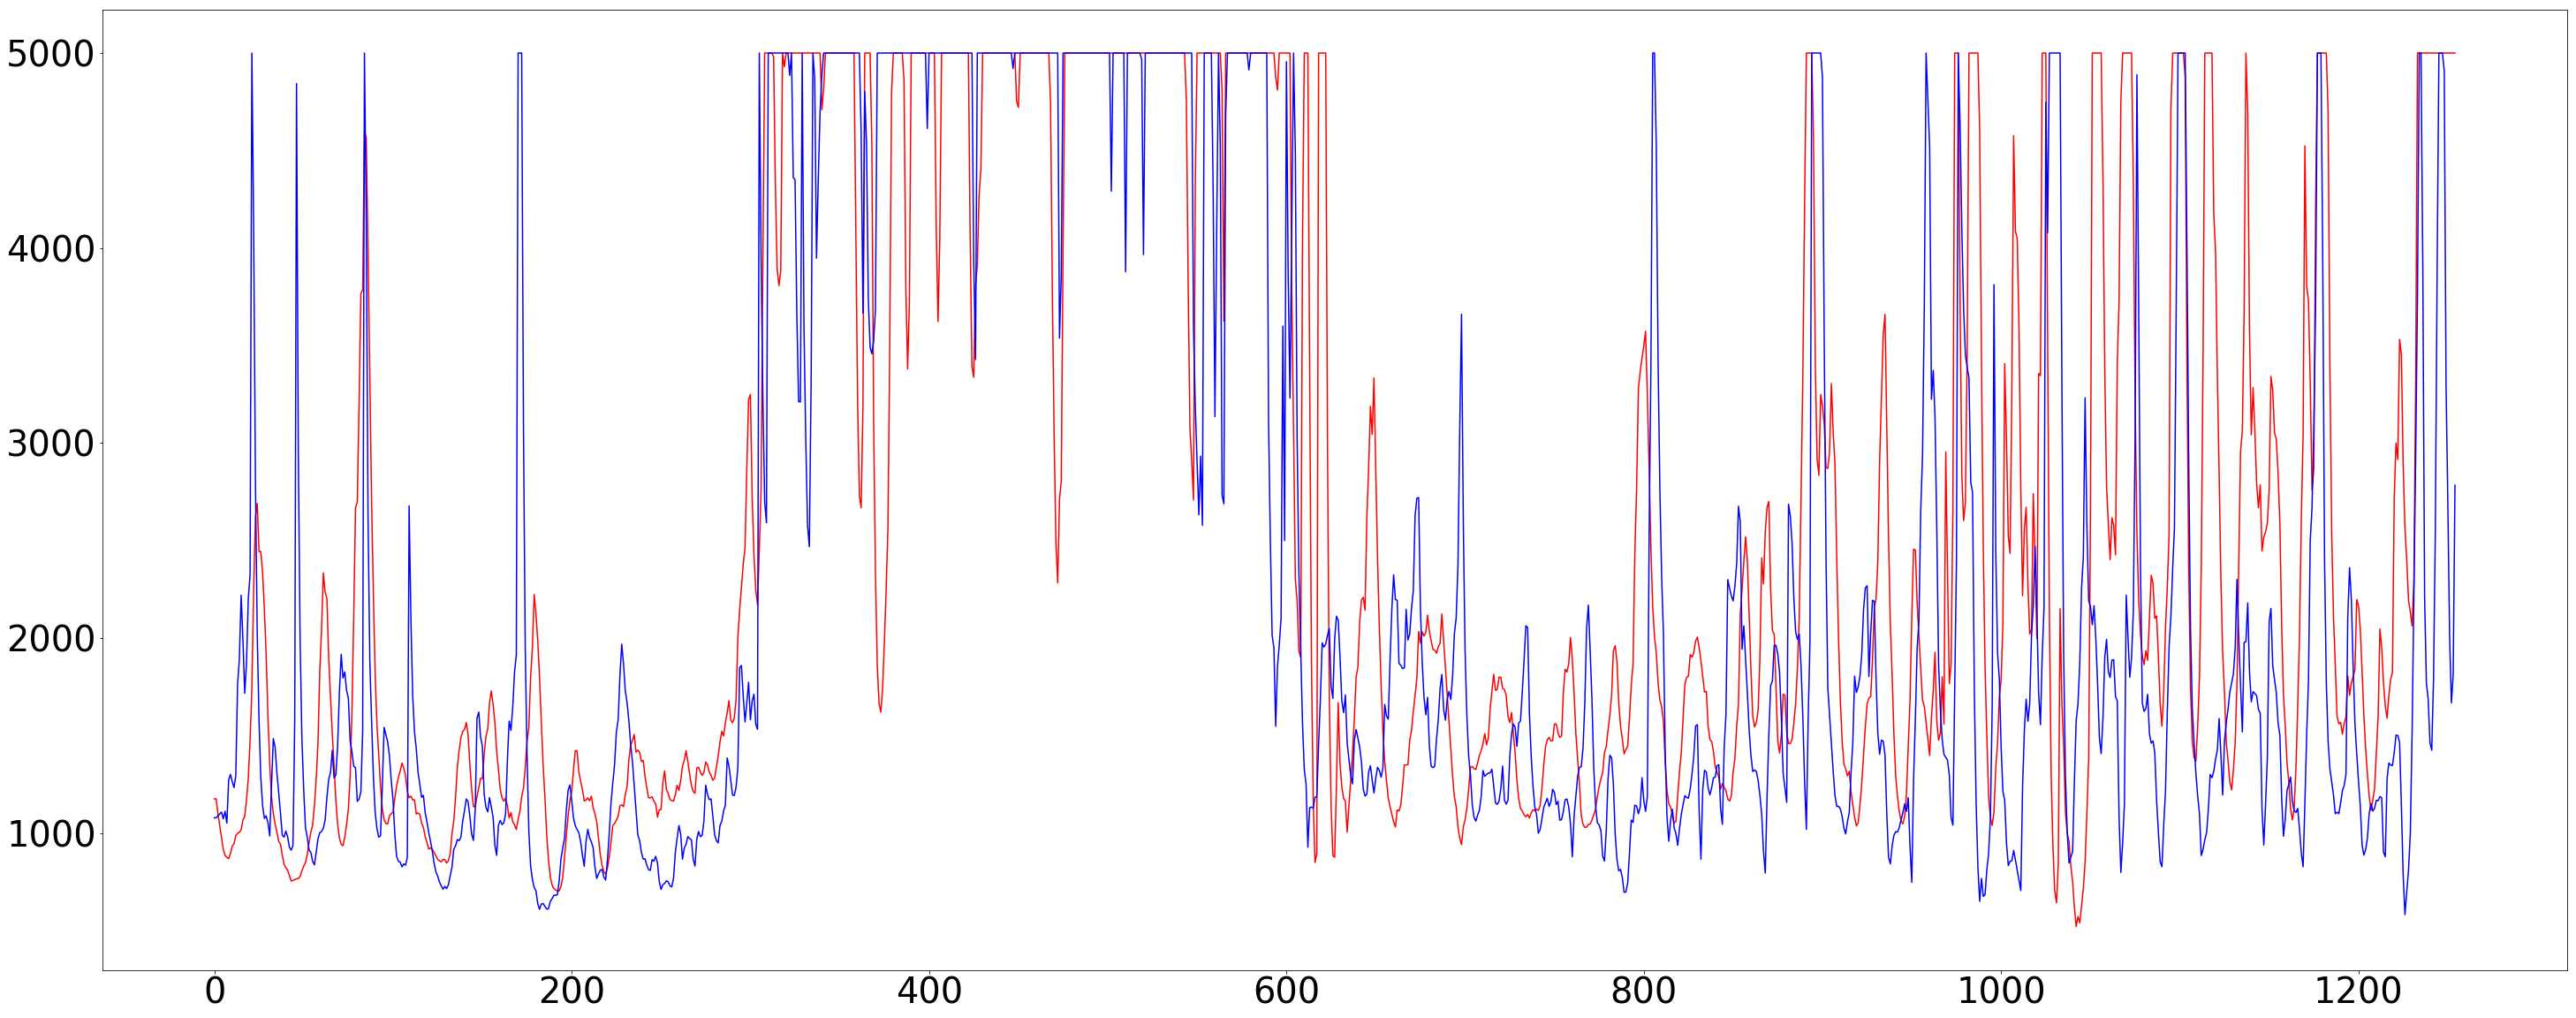

In [162]:
frames = range(0,len(L_Line.getCurvatureLog()))

f, axarr = plt.subplots(1, 1, figsize=(50,20))

leftCurvLog = np.array(L_Line.getCurvatureLog(), dtype = np.float32)
leftCurvLog[leftCurvLog > 5000] = 5000
axarr.plot(frames, leftCurvLog, color='red')
axarr.tick_params(labelsize=40)

rightCurvLog = np.array(R_Line.getCurvatureLog(), dtype = np.float32)
rightCurvLog[rightCurvLog > 5000] = 5000
axarr.plot(frames, rightCurvLog, color='blue')

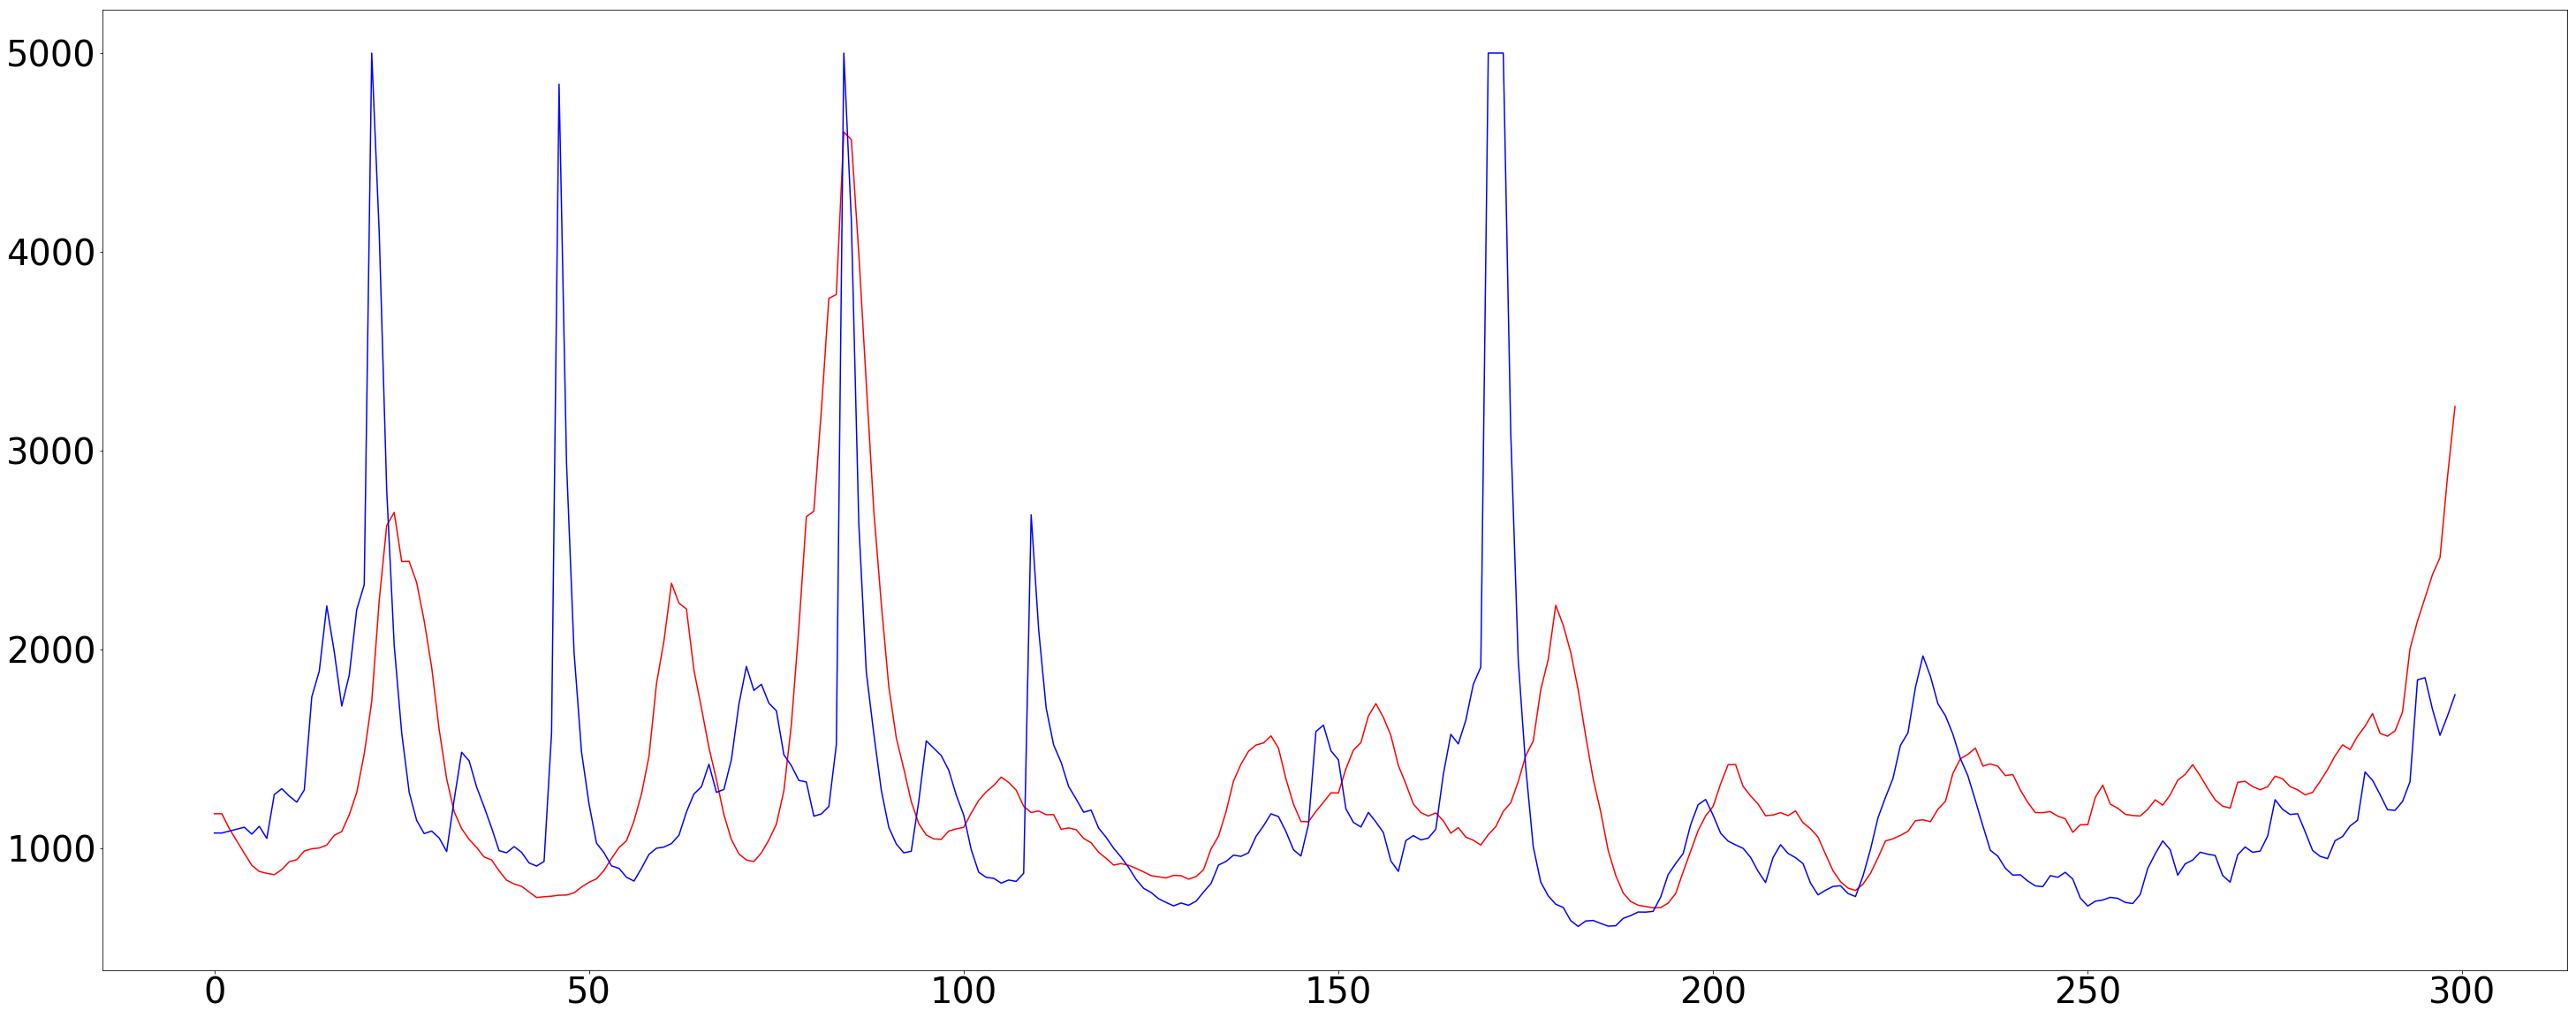

In [163]:
frames = range(0,300)

f, axarr = plt.subplots(1, 1, figsize=(50,20))

leftCurvLog = np.array(L_Line.getCurvatureLog(), dtype = np.float32)
leftCurvLog[leftCurvLog > 5000] = 5000
axarr.plot(frames, leftCurvLog[0:300], color='red')
axarr.tick_params(labelsize=40)

rightCurvLog = np.array(R_Line.getCurvatureLog(), dtype = np.float32)
rightCurvLog[rightCurvLog > 5000] = 5000
axarr.plot(frames, rightCurvLog[0:300], color='blue')

## 9. Challenge

### 9.1 Video processing 

In [93]:
L_Line = Line()
R_Line = Line()

clip_output = 'test_videos_output/ChallengeAdvanceLanDetectionPlus.mp4'

clip = VideoFileClip("challenge_video.mp4")
#clip = clip.fl_image(pipelinePlus).subclip(0,10)
clip = clip.fl_image(pipelinePlus)
%time clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/ChallengeAdvanceLanDetectionPlus.mp4
[MoviePy] Writing video test_videos_output/ChallengeAdvanceLanDetectionPlus.mp4


100%|██████████| 485/485 [01:25<00:00,  5.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/ChallengeAdvanceLanDetectionPlus.mp4 

CPU times: user 1min 41s, sys: 1.04 s, total: 1min 42s
Wall time: 1min 26s
